In [43]:
import numpy as np

datasets = np.load('npz/ObjectDetection.npz', allow_pickle=True)
images, numbers, bboxes = datasets['images'], datasets['numbers'], datasets['bboxes']

max_label_length = 4
labels = []
for num in numbers:
    cls = [1] * num if num != 0 else [0]
    cls += [0] * (max_label_length - len(cls))
    labels.append(cls)

# labels = np.array(labels)

print(images.shape, numbers.shape, bboxes.shape, len(labels))

print(images.max(), images.min())
print(bboxes[9000:9010])
print(labels[9000:9010])
# labels = np.array(labels)

dataset = {
    'images' : images,
    'bboxes' : bboxes,
    'cls' : labels
}

print(dataset['images'].shape)
print(dataset['bboxes'].shape)
print(len(dataset['cls']))


(13276, 24, 32, 1) (13276,) (13276, 4, 4) 13276
255 0
[[[0.25       0.625      0.46875    1.        ]
  [0.         0.         0.25       0.33333333]
  [0.46875    0.54166667 0.71875    0.95833333]
  [0.8125     0.66666667 1.         1.        ]]

 [[0.28125    0.625      0.5        1.        ]
  [0.46875    0.54166667 0.75       1.        ]
  [0.         0.         0.25       0.33333333]
  [0.8125     0.625      1.         0.83333333]]

 [[0.3125     0.66666667 0.5        1.        ]
  [0.4375     0.54166667 0.78125    0.95833333]
  [0.8125     0.54166667 1.         0.83333333]
  [0.         0.         0.1875     0.29166667]]

 [[0.375      0.66666667 0.53125    1.        ]
  [0.53125    0.58333333 0.78125    0.95833333]
  [0.78125    0.58333333 1.         0.83333333]
  [0.         0.         0.1875     0.375     ]]

 [[0.375      0.66666667 0.5625     1.        ]
  [0.5        0.54166667 0.8125     0.91666667]
  [0.         0.         0.21875    0.33333333]
  [0.84375    0.54166667 1

In [44]:
print(labels[9000])

[1, 1, 1, 1]


(24, 32, 1)
1
32
tf.Tensor(
[[ 8. 15. 15. 24.]
 [ 0.  0.  8.  8.]
 [15. 13. 23. 23.]
 [26. 16. 32. 24.]], shape=(4, 4), dtype=float64)


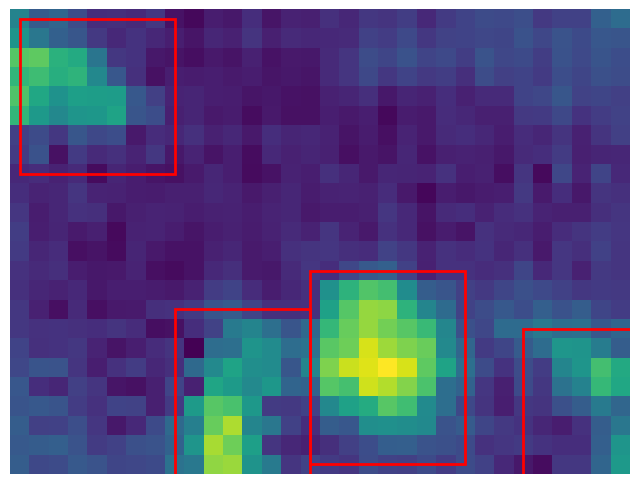

[1, 1, 1, 1]


In [45]:
import matplotlib.pyplot as plt
import tensorflow as tf
images = dataset['images']
# numbers =dataset['numbers']
bboxes = dataset['bboxes']
cls = dataset['cls']

boxes = bboxes[9000]
plt.figure(figsize = (8, 8))
plt.axis('off')
image = images[9000]
print(image.shape)
print(image.shape[2])
print(image.shape[1])
plt.imshow(images[9000])
ax = plt.gca()
boxes = tf.stack([
	boxes[:, 0] * images.shape[2],
	boxes[:, 1] * images.shape[1],
	boxes[:, 2] * images.shape[2],
	boxes[:, 3] * images.shape[1]], axis = -1
)

print(boxes)

for box in boxes:
	xmin, ymin = box[:2]
	w, h = box[2:] - box[:2]
	patch = plt.Rectangle(
		[xmin, ymin], w, h, fill = False, edgecolor = [1, 0, 0], linewidth = 2
	)
	ax.add_patch(patch)
plt.show()
print(cls[9000])

In [46]:
import os
import random
import tensorflow as tf

IMG_SIZE_WIDTH = images.shape[2]
IMG_SIZE_HEIGHT = images.shape[1]
N_DATA = images.shape[0]
N_TRAIN = int(images.shape[0] * 0.7)
N_VAL = images.shape[0] - N_TRAIN
LOG_DIR = 'ObjectDetectionLog'

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

print("IMG_SIZE_WIDTH:  ", IMG_SIZE_WIDTH)
print("IMG_SIZE_HEIGHT: ", IMG_SIZE_HEIGHT)
print("N_DATA:          ", N_DATA)
print("N_TRAIN:         ", N_TRAIN)
print("N_VAL:           ", N_VAL)


shuffle_list = list(range(N_DATA))
random.shuffle(shuffle_list)

train_idx_list = shuffle_list[:N_TRAIN]
val_idx_list = shuffle_list[N_TRAIN:]

cur_dir = os.getcwd()
tfr_dir = os.path.join(cur_dir, 'tfrecord/ObjectDetection')
os.makedirs(tfr_dir, exist_ok=True)

tfr_train_dir = os.path.join(tfr_dir, 'od_train.tfr')
tfr_val_dir = os.path.join(tfr_dir, 'od_val.tfr')

writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

IMG_SIZE_WIDTH:   32
IMG_SIZE_HEIGHT:  24
N_DATA:           13276
N_TRAIN:          9293
N_VAL:            3983


In [47]:
images.max(), images.min()

(255, 0)

In [48]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list = tf.train.BytesList(value = [value]))

def _float_feature(value):
    return tf.train.Feature(float_list = tf.train.FloatList(value = value))

def _int64_feature(value):
    return tf.train.Feature(int64_list = tf.train.Int64List(value = [value]))


def _bytes_feature_list(value_list):
    """value_list가 리스트일 때, 이를 serialize하여 bytes list로 변환하는 함수."""
    value_list = [tf.io.serialize_tensor(tf.constant(v)).numpy() for v in value_list]
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value_list))


In [49]:

for idx in train_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_train.write(example.SerializeToString())
writer_train.close()


In [50]:

for idx in val_idx_list:
    bbox = bboxes[idx]
    xmin, ymin, xmax, ymax = bbox[:, 0], bbox[:, 1], bbox[:, 2], bbox[:, 3]
    bbox = np.stack([xmin, ymin, xmax, ymax], axis=-1).flatten()

    image = images[idx]
    bimage = image.tobytes()

    number = numbers[idx]
    class_id = cls[idx]
    # print(len(cls))
    serialized_cls = tf.io.serialize_tensor(tf.constant(class_id)).numpy()

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(bimage),
        'bbox': _float_feature(bbox),
        'label': _bytes_feature(serialized_cls),
        # 'number': _int64_feature(number)
    }))
    
    writer_val.write(example.SerializeToString())
writer_val.close()


In [51]:
AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT =24
RES_WIDTH = 32
# N_EPOCHS = 100
# N_BATCH = 8
# LR = 0.0005


def _parse_function(tfrecord_serialized):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'bbox': tf.io.VarLenFeature(tf.float32),  
        'label': tf.io.FixedLenFeature([], tf.string),
        # 'number': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_features = tf.io.parse_single_example(tfrecord_serialized, features)

    image = tf.io.decode_raw(parsed_features['image'], tf.uint8)
    image = tf.reshape(image, [RES_HEIGHT, RES_WIDTH, 1])
    image = image / tf.reduce_max(image)
    image = tf.cast(image, tf.float32) 
    # image = image / tf.reduce_max(image)

    bbox = tf.sparse.to_dense(parsed_features['bbox']) 
    bbox = tf.cast(bbox, tf.float32)
    # num_boxes = tf.shape(bbox)[0] // 4
    bbox = tf.reshape(bbox, [-1, 4])

    serialized_cls = parsed_features['label']
    label = tf.io.parse_tensor(serialized_cls, out_type=tf.int32)
    
    # number = tf.cast(parsed_features['number'], tf.int64)
    return image, bbox, label


train_dataset = tf.data.TFRecordDataset(tfr_train_dir)
train_dataset = train_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=N_TRAIN).prefetch(AUTOTUNE).batch(N_BATCH, drop_remainder=True)

val_dataset = tf.data.TFRecordDataset(tfr_val_dir)
val_dataset = val_dataset.map(_parse_function, num_parallel_calls=AUTOTUNE)


(24, 32, 1)
tf.Tensor([1 1 1 0], shape=(4,), dtype=int32)
tf.Tensor(
[[0.0625    0.5       0.40625   0.8333333]
 [0.53125   0.375     0.84375   0.75     ]
 [0.        0.625     0.0625    0.7916667]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)
(24, 32, 1)
tf.Tensor(
[[ 2. 12. 13. 20.]
 [17.  9. 27. 18.]
 [ 0. 15.  2. 19.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


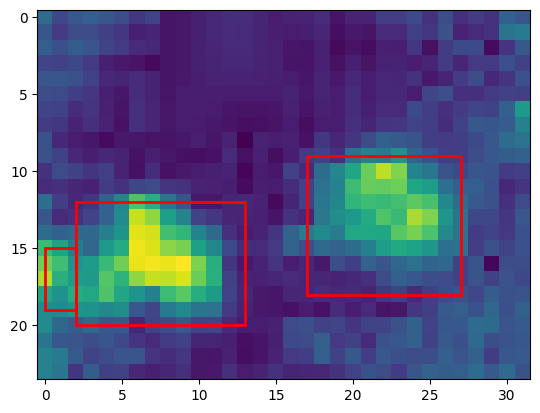

(24, 32, 1)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[0.         0.41666666 0.3125     0.7916667 ]
 [0.59375    0.8333333  0.78125    1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
(24, 32, 1)
tf.Tensor(
[[ 0. 10. 10. 19.]
 [19. 20. 25. 24.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


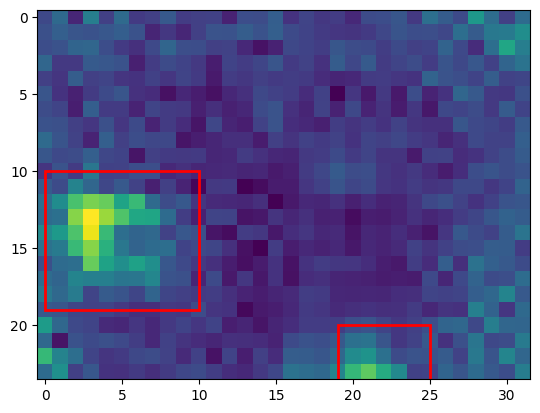

(24, 32, 1)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[0.         0.         0.25       0.375     ]
 [0.         0.33333334 0.25       0.7083333 ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
(24, 32, 1)
tf.Tensor(
[[ 0.  0.  8.  9.]
 [ 0.  8.  8. 17.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


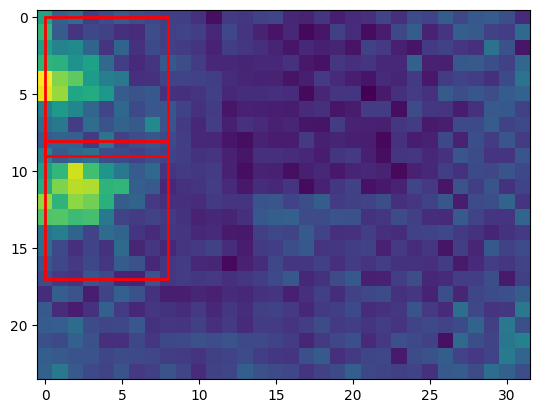

(24, 32, 1)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[0.75       0.04166667 1.         0.375     ]
 [0.46875    0.20833333 0.78125    0.625     ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
(24, 32, 1)
tf.Tensor(
[[24.  1. 32.  9.]
 [15.  5. 25. 15.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


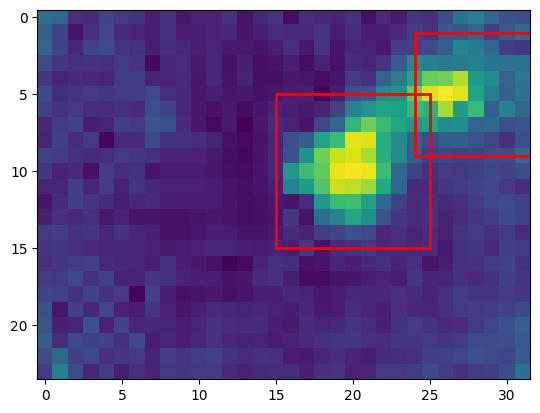

(24, 32, 1)
tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
tf.Tensor(
[[0.        0.5       0.3125    0.8333333]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)
(24, 32, 1)
tf.Tensor(
[[ 0. 12. 10. 20.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


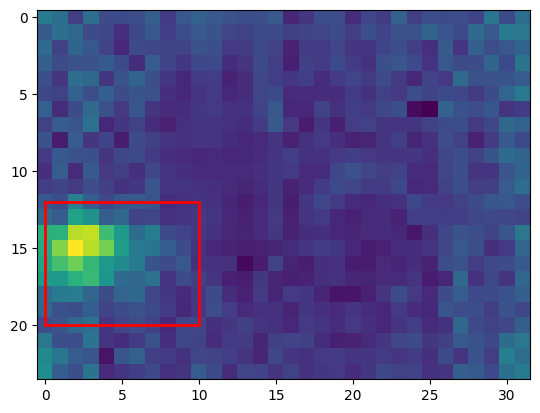

In [52]:
import matplotlib.pyplot as plt

for image, bbox, label in val_dataset.take(5):
    image = image.numpy()
    print(image.shape)
    print(label)
    # plt.axis('off')
    plt.imshow(image)
    ax = plt.gca()  
    print(bbox)

    boxes = tf.stack(
    	[
    	 bbox[:,0] * image.shape[1],
    	 bbox[:,1] * image.shape[0],
    	 bbox[:,2] * image.shape[1],
    	 bbox[:,3] * image.shape[0]
    	], axis = -1
    )
    print(image.shape)
    print(boxes)
    for box in boxes:
        xmin, ymin = box[:2]
        w, h = box[2:] - box[:2]
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)
    plt.show()

In [53]:
def convert_to_xywh(boxes):    
    return tf.concat(
        [(boxes[..., :2] + boxes[..., 2:]) / 2.0, boxes[..., 2:] - boxes[..., :2]],
        axis=-1
    )

In [54]:
def convert_to_corners(boxes):
    return tf.concat(
        [boxes[..., :2] - boxes[..., 2:] / 2.0, boxes[..., :2] + boxes[..., 2:] / 2.0],
        axis=-1
    )



In [55]:
for image, bbox, label in val_dataset.take(5):
    print(bbox)
    print(convert_to_xywh(bbox))

tf.Tensor(
[[0.0625    0.5       0.40625   0.8333333]
 [0.53125   0.375     0.84375   0.75     ]
 [0.        0.625     0.0625    0.7916667]
 [0.        0.        0.        0.       ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.234375   0.6666666  0.34375    0.3333333 ]
 [0.6875     0.5625     0.3125     0.375     ]
 [0.03125    0.7083334  0.0625     0.16666669]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.         0.41666666 0.3125     0.7916667 ]
 [0.59375    0.8333333  0.78125    1.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.15625    0.6041667  0.3125     0.37500003]
 [0.6875     0.9166666  0.1875     0.16666669]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]], shape=(4, 4), dtype=float32)
tf.Tensor(
[[0.         0.         0.25       0.375     ]
 [0.         0.33333334 0.25       0.7

In [56]:
def resize_and_pad_image(image, min_side=96, max_side=128):
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    print(f"image_shape: {image_shape}")
    ratio = min_side / tf.reduce_min(image_shape)
    print(f"ratio: {ratio}")
    if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)
    print(f"ratio: {ratio}")

    new_image_shape = ratio * image_shape
    print(f"new_image_shape: {new_image_shape}")

    image = tf.image.resize(image, 
                            tf.cast(new_image_shape, dtype=tf.int32), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    print(f"image: {image.shape}")

    return image, new_image_shape, ratio


In [57]:
def preprocess_data(image, gt_boxes, cls_ids):
    # image = sample["images"]
    # bbox = sample["bboxes"]
    cls_ids = tf.cast(cls_ids, dtype = tf.int32)
    image, image_shape, _ = resize_and_pad_image(image)
    
    bbox = tf.stack([
        gt_boxes[:, 0] * image_shape[1],
        gt_boxes[:, 1] * image_shape[0],
        gt_boxes[:, 2] * image_shape[1],
        gt_boxes[:, 3] * image_shape[0]],
        axis = -1
    )
    
    bbox = convert_to_xywh(bbox)

    return image, bbox, cls_ids

In [58]:
for image, bbox, label in val_dataset.take(1):
    resize_and_pad_image(image)

image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)


tf.Tensor([1 1 1 0], shape=(4,), dtype=int32)
image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[30. 64. 44. 32.]
 [88. 54. 40. 36.]
 [ 4. 68.  8. 16.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


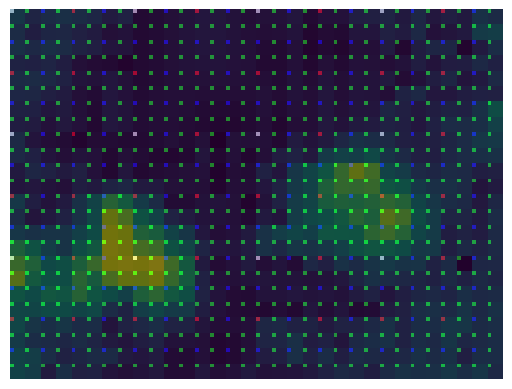

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.012244898, shape=(), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[20. 58. 40. 36.]
 [88. 88. 24. 16.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


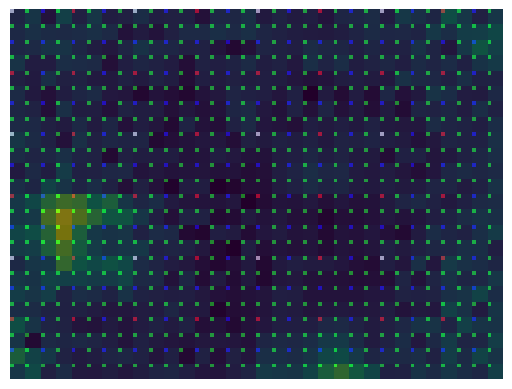

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.04761905, shape=(), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[16. 18. 32. 36.]
 [16. 50. 32. 36.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


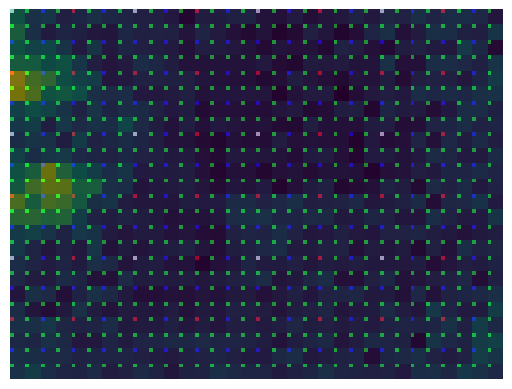

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.004016064, shape=(), dtype=float32)
tf.Tensor([1 1 0 0], shape=(4,), dtype=int32)
image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[112.  20.  32.  32.]
 [ 80.  40.  40.  40.]
 [  0.   0.   0.   0.]
 [  0.   0.   0.   0.]], shape=(4, 4), dtype=float32)


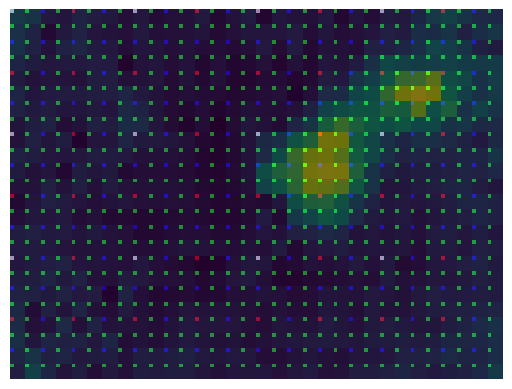

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.012096774, shape=(), dtype=float32)
tf.Tensor([1 0 0 0], shape=(4,), dtype=int32)
image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
(96, 128, 1)
(96, 128, 3)
tf.Tensor(
[[20. 64. 40. 32.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)


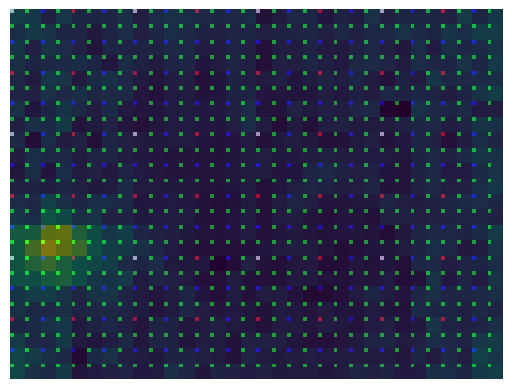

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


In [59]:
for image, bbox, label in val_dataset.take(5):
    print(label)
    img, bbox, class_id = preprocess_data(image, bbox, label)
    print(img.shape) # (72, 96, 1)

    anchor_img = np.zeros((*img.shape[:2], 3), dtype=np.uint8)
    print(anchor_img.shape)

    print(bbox)

    strides = [4, 8, 16, 32]
    colors = {
        4: [0, 255, 0],  # 초록색
        8: [0, 0, 255],  # 파란색
        16: [255, 0, 0],   # 빨간색
        32:[255, 255, 255],  # 노란색
        # 64:[255, 255, 0],  # 노란색
    }

    for stride in strides:
        color = colors[stride]
        for y in range(0, anchor_img.shape[0], stride):
            for x in range(0, anchor_img.shape[1], stride):
                anchor_img[y, x, :] = color

    # 이미지 표시
    plt.imshow(img, alpha=1)  
    plt.imshow(anchor_img, alpha=0.5) 
    plt.axis('off')
    plt.show()
    print(tf.reduce_max(image), tf.reduce_min(image))

image_shape: [24. 32.]
ratio: 4.0
ratio: 4.0
new_image_shape: [ 96. 128.]
image: (96, 128, 1)
tf.Tensor([1 1 1 0], shape=(4,), dtype=int32)
tf.Tensor(
[[30. 64. 44. 32.]
 [88. 54. 40. 36.]
 [ 4. 68.  8. 16.]
 [ 0.  0.  0.  0.]], shape=(4, 4), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.012244898, shape=(), dtype=float32)
bbox:  tf.Tensor(
[[  8.  48.  52.  80.]
 [ 68.  36. 108.  72.]
 [  0.  60.   8.  76.]
 [  0.   0.   0.   0.]], shape=(4, 4), dtype=float32)


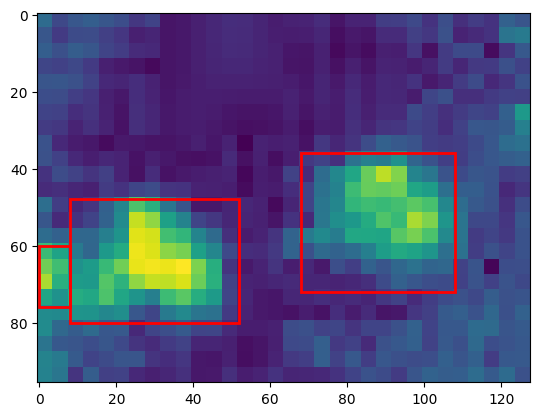

tf.Tensor([1 1 1 0], shape=(4,), dtype=int32)


In [60]:
for image, bbox, label in val_dataset.take(1):
    img, box, label = preprocess_data(image, bbox, label)
    print(label)
    print(box)
    print(tf.reduce_max(image), tf.reduce_min(image))
    # 이미지 시각화
    plt.imshow(img)
    ax = plt.gca()
    w = img.shape[1]
    h = img.shape[0]
    boxes = tf.stack(
        [
            box[:, 0] - 0.5 * box[:, 2] ,  # xmin = x_center - width/2
            box[:, 1] - 0.5 * box[:, 3] ,  # ymin = y_center - height/2
            box[:, 0] + 0.5 * box[:, 2] ,  # xmax = x_center + width/2
            box[:, 1] + 0.5 * box[:, 3]    # ymax = y_center + height/2
        ], axis=-1
    )
    print("bbox: ", boxes)
    # 각 바운딩 박스에 대해 반복하여 그리기
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        w, h = xmax - xmin, ymax - ymin
        patch = plt.Rectangle(
            [xmin, ymin], w, h, fill=False, edgecolor=[1, 0, 0], linewidth=2
        )
        ax.add_patch(patch)

    plt.show()
    print(label)


In [61]:
class AnchorBox:
    def __init__(self):
        self.aspect_ratios = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25]        
        self.scales = [2** x for x in [0, 1/3, 1/2, 2/3]]
        self._num_anchors = len(self.aspect_ratios) * len(self.scales)
        self._strides = [2 ** i for i in range(2, 6)]
        self._areas = [x ** 2 for x in [8.0, 16.0, 32.0, 64.0]]
        self._anchor_dims = self._compute_dims()

    def _compute_dims(self):
        anchor_dims_all = []

        for area in self._areas:
            anchor_dims = []
            for ratio in self.aspect_ratios: 
                anchor_height = tf.math.sqrt(area / ratio)
                anchor_width = area / anchor_height
                dims = tf.reshape(
                    tf.stack([anchor_width, anchor_height], axis = -1), [1, 1, 2]
                )
                for scale in self.scales: 
                    anchor_dims.append(scale * dims) 
            anchor_dims_all.append(tf.stack(anchor_dims, axis = -2))
        return anchor_dims_all 
    
    def _get_anchors(self, feature_height, feature_width, level):
        rx = tf.range(feature_width, dtype = tf.float32) + 0.5
        ry = tf.range(feature_height, dtype = tf.float32) + 0.5

        centers = tf.stack(tf.meshgrid(rx, ry), axis = -1) * self._strides[level - 2]
        # print(f"centers: {centers}")
        centers = tf.expand_dims(centers, axis = -2)
        # print(f"centers: {centers}")
        centers = tf.tile(centers, [1, 1, self._num_anchors, 1])
        # print(f"centers: {centers}")

        dims = tf.tile(
            self._anchor_dims[level - 2], [feature_height, feature_width, 1, 1] 
        )
        # print(f"dims: {dims}")

        
        anchors = tf.concat([centers, dims], axis=-1) 
        # print(f"anchors: {anchors}")

        # print(f"{tf.reshape(anchors, [feature_height * feature_width * self._num_anchors, 4]).shape}")

        return tf.reshape(
            anchors, [feature_height * feature_width * self._num_anchors, 4]
        )

    def get_anchors(self, image_height, image_width):
        anchors = [
            self._get_anchors(
                tf.math.ceil(image_height / 2 ** i), # 올림
                tf.math.ceil(image_width / 2 ** i),
                i
            )
            for i in range(2, 6)
        ]

        anchors = tf.concat(anchors, axis=0)

        # 앵커 박스의 좌표를 이미지 크기 내로 제한
        anchors = tf.clip_by_value(anchors, 0, [image_height, image_width, image_height, image_width])
        # return tf.concat(anchors, axis=0)
        return anchors

Anchor 음수 값: False
tf.Tensor(
[[ 2.         2.         4.        16.       ]
 [ 2.         2.         5.0396843 20.158737 ]
 [ 2.         2.         5.656854  22.627417 ]
 ...
 [96.        80.        96.        53.756634 ]
 [96.        80.        96.        60.33978  ]
 [96.        80.        96.        67.72911  ]], shape=(36720, 4), dtype=float32)
(36720, 4)


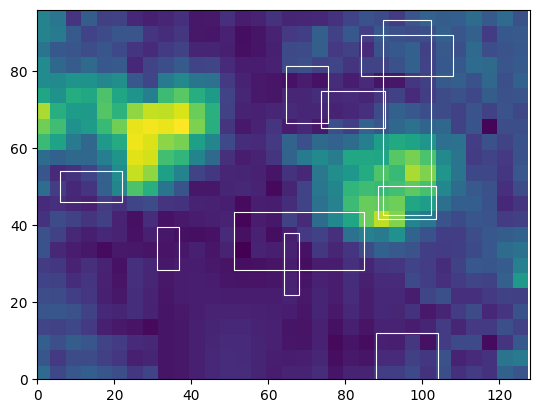

In [62]:
anchors = AnchorBox()
anchor = anchors.get_anchors(96, 128)

has_negative_values = tf.reduce_any(tf.less(anchor, 0))
print("Anchor 음수 값:", has_negative_values.numpy())

print(anchor)
print(anchor.shape)
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bounding_boxes(data, num_samples):
    fig, ax = plt.subplots()
    ax.set_ylim(0, 96)
    ax.set_xlim(0, 128)
    

    ax.imshow(img)
    # print(img.shape)
    data_np = data.numpy()

    if len(data) > num_samples:
        sampled_indices = np.random.choice(len(data), num_samples, replace=False)
        sample_data = data_np[sampled_indices]
    else : 
        sample_data = data_np

    for center_x, center_y, width, height in sample_data:
        top_left_x = center_x - width / 2
        top_left_y = center_y - height / 2

        rect = patches.Rectangle((top_left_x, top_left_y), width, height, linewidth=0.8, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

draw_bounding_boxes(anchor, 10)

# 36288


In [63]:
def compute_iou(boxes1, boxes2):
    boxes1_corners = convert_to_corners(boxes1)
    boxes2_corners = convert_to_corners(boxes2)
    lu = tf.maximum(boxes1_corners[:, None, :2], boxes2_corners[:, :2])
    rd = tf.minimum(boxes1_corners[:, None, 2:], boxes2_corners[:, 2:])  
    intersection = tf.maximum(rd - lu, 0.0)
    intersection_area = intersection[:, :, 0] * intersection[:, :, 1]
    boxes1_area = boxes1[:, 2] * boxes1[:, 3]
    boxes2_area = boxes2[:, 2] * boxes2[:, 3]
    union_area = tf.maximum(boxes1_area[:, None] + boxes2_area - intersection_area, 1e-8)
    return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)


In [64]:
class LabelEncoder:
    def __init__(self):
        self._anchor_box = AnchorBox()
        self._box_variance = tf.convert_to_tensor(
            [0.1, 0.1, 0.2, 0.2], dtype=tf.float32)
    
    def _match_anchor_boxes(self, anchor_boxes, gt_boxes, match_iou = 0.5, ignore_iou = 0.4):
        iou_matrix = compute_iou(anchor_boxes, gt_boxes)
        max_iou = tf.reduce_max(iou_matrix, axis=1)
        matched_gt_idx = tf.argmax(iou_matrix, axis = 1)

        positive_mask = tf.greater_equal(max_iou, match_iou)
        negative_mask = tf.less(max_iou, ignore_iou)

        ignore_mask = tf.logical_not(tf.logical_or(positive_mask, negative_mask))
        return (
            matched_gt_idx,
            tf.cast(positive_mask, dtype = tf.float32),
            tf.cast(ignore_mask, dtype = tf.float32),
        )
    
    def _compute_box_target(self, anchor_boxes, matched_gt_boxes):
        box_target = tf.concat(
            [
                (matched_gt_boxes[:, :2] - anchor_boxes[:, :2]) / anchor_boxes[:, 2:],
                tf.math.log(matched_gt_boxes[:, 2:] / anchor_boxes[:, 2:])
            ],
            axis = -1,
        )
        box_target = box_target / self._box_variance
        return box_target
    
    def _encode_sample(self, image_shape, gt_boxes, cls_ids):        
        anchor_boxes = self._anchor_box.get_anchors(image_shape[1], image_shape[2])
        cls_ids = tf.cast(cls_ids, dtype=tf.float32)
        matched_gt_idx, positive_mask, ignore_mask = self._match_anchor_boxes(
            anchor_boxes, gt_boxes
        )
        matched_gt_boxes = tf.gather(gt_boxes, matched_gt_idx)
        box_target = self._compute_box_target(anchor_boxes, matched_gt_boxes)
        matched_gt_cls_ids = tf.gather(cls_ids, matched_gt_idx)
        cls_target = tf.where(
            tf.not_equal(positive_mask, 1.0), -1.0, matched_gt_cls_ids
        )
        cls_target = tf.where(tf.equal(ignore_mask, 1.0), -2.0, cls_target)
        cls_target = tf.expand_dims(cls_target, axis=-1)
        label = tf.concat([box_target, cls_target], axis=-1)
        return label

    def encode_batch(self, batch_images, gt_boxes, cls_ids):       
        images_shape = tf.shape(batch_images)
        batch_size = images_shape[0]

        labels = tf.TensorArray(dtype=tf.float32, size=batch_size, dynamic_size=True)
        for i in range(batch_size):
          label = self._encode_sample(images_shape, gt_boxes[i], cls_ids[i])
          labels = labels.write(i, label)
        # batch_images = tf.keras.applications.resnet.preprocess_input(batch_images)
        return batch_images, labels.stack()

In [65]:
label_encoder = LabelEncoder()

autotune = tf.data.AUTOTUNE
num_classes = 1
batch_size = 32

train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(batch_size * 8)

train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, 
    padded_shapes = ([96, 128, 1], [4, 4], [4]),
    padding_values=(0.0, 1e-8, 0), 
    drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
# train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=batch_size, 
    padded_shapes = ([96, 128, 1], [4, 4], [4]),
    padding_values=(0.0, 1e-8, 0), 
    drop_remainder=True
)
val_dataset = val_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)

# val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

image_shape: Tensor("Cast:0", shape=(2,), dtype=float32)
ratio: Tensor("truediv:0", shape=(), dtype=float32)
ratio: Tensor("cond/Identity:0", shape=(), dtype=float32)
new_image_shape: Tensor("mul_1:0", shape=(2,), dtype=float32)
image: (None, None, 1)
image_shape: Tensor("Cast:0", shape=(2,), dtype=float32)
ratio: Tensor("truediv:0", shape=(), dtype=float32)
ratio: Tensor("cond/Identity:0", shape=(), dtype=float32)
new_image_shape: Tensor("mul_1:0", shape=(2,), dtype=float32)
image: (None, None, 1)


In [66]:
# train_dataset에서 하나의 배치를 가져옵니다
positive_count = []
negative_count = []
ignore_count = []
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    print(labels.shape)

    # labels 텐서에서 positive, negative, ignore 값의 개수를 계산
    positive_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], 1.0), tf.int32))
    negative_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -1.0), tf.int32))
    ignore_count = tf.reduce_sum(tf.cast(tf.equal(labels[:, :, 4], -2.0), tf.int32))

    print("Positive 개수:", positive_count.numpy())
    print("Negative 개수:", negative_count.numpy())
    print("Ignore 개수:", ignore_count.numpy())


(32, 36720, 5)
Positive 개수: 1563
Negative 개수: 1169268
Ignore 개수: 4209


In [67]:
for batch in train_dataset.take(1):
    images, labels = batch
    print("원본 레이블 shape:", labels.shape)

    # ignore 상태가 아닌 앵커 박스만 필터링
    mask = tf.not_equal(labels[:, :, 4], -2.0)
    filtered_labels = tf.boolean_mask(labels, mask)

    # 필터링된 레이블을 원하는 크기로 조절
    # 예: 36288개로 조절
    desired_count = 36288
    filtered_labels = filtered_labels[:desired_count, :]
    print("조정된 레이블 shape:", filtered_labels.shape)


원본 레이블 shape: (32, 36720, 5)
조정된 레이블 shape: (36288, 5)


In [68]:
def cut_labels(images, labels):
    # ignore 상태가 아닌 앵커 박스만 필터링
    mask = tf.not_equal(labels[:, 4], -2.0)
    filtered_labels = tf.boolean_mask(labels, mask)

    # 필터링된 레이블을 원하는 크기로 조절
    desired_count = 36288
    # 주의: 여기서 filtered_labels의 크기가 desired_count보다 작을 수 있으므로, 적절한 처리가 필요합니다.
    if tf.shape(filtered_labels)[0] > desired_count:
        filtered_labels = filtered_labels[:desired_count, :]

    return images, filtered_labels






# 원본 train_dataset에 process_labels 함수 적용
train_dataset = train_dataset.unbatch().map(cut_labels).batch(batch_size)
val_dataset = val_dataset.unbatch().map(cut_labels).batch(batch_size)

# buffer_size = 1000
# 필요한 경우 배치 크기, 셔플, 반복 등을 적용
# train_dataset = new_train_dataset.batch(batch_size).shuffle(buffer_size).repeat()
# val_dataset = new_val_dataset.batch(batch_size).shuffle(buffer_size).repeat()


In [69]:
# for batch in train_dataset.take(1):

#     images, labels = batch
#     plt.imshow(images[4])
#     plt.show()
#     # print(labels[:, :, 4])
#     print(np.argwhere(labels[4, :, 4:] != -1))


In [70]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D
from keras.regularizers import l2
from keras.layers import Add

class BackBone:
    def __init__(self):
        self.l2_regularizer = l2(0.001)

    def residual_layer(self, feature_map, latent, name:str):
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = Dropout(0.3)(feature_map)

        feature_map = ZeroPadding2D(padding=((0, 1), (0, 1)), name=name+'_pad')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'valid', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name)(feature_map)
        latent =  BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(latent)
        latent = BatchNormalization()(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def __call__(self, input_shape=(96, 128, 1)):
        inputs_image = Input(shape=input_shape)
        upsample_layer = Conv2DTranspose(filters = 16, kernel_size = 3, strides = (1, 1), padding = 'same')(inputs_image)
        block_1 = self.feature_extraction_block(upsample_layer, 32, 64,'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 32, 64,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 32, 64, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 32, 64, 'block_4')
        block_3 = self.feature_extraction_block(block_2_output, 32, 64,'block_5')
        block_3_output = self.convolutional_residual_block(block_3, 32, 64,'block_6')

        model = Model(inputs_image, block_3_output)
        return model

In [71]:
backbone = BackBone()
model = backbone()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 96, 128, 1)]         0         []                            
                                                                                                  
 conv2d_transpose_2 (Conv2D  (None, 96, 128, 16)          160       ['input_5[0][0]']             
 Transpose)                                                                                       
                                                                                                  
 block_1 (Conv2D)            (None, 96, 128, 32)          4640      ['conv2d_transpose_2[0][0]']  
                                                                                                  
 batch_normalization_24 (Ba  (None, 96, 128, 32)          128       ['block_1[0][0]']       

In [72]:
import keras
def get_backbone():
    backbone = BackBone() 
    backbone = backbone(input_shape=[None, None, 1])

    b2_output, b4_output, b6_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['block_2_output', 'block_4_output', 'block_6_output']
    ]

    return keras.Model(
        inputs = [backbone.inputs], outputs=[b2_output, b4_output, b6_output]
    )

In [73]:
# block_2_output (Add)        (None, 48, 64, 64)

# block_4_output (Add)        (None, 24, 32, 64)

# block_6_output (Add)        (None, 12, 16, 64)

class FeaturePyramid(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = get_backbone()
        self.conv_c2_1x1 = keras.layers.Conv2D(16, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(16, 1, 1, "same")
        self.conv_c6_1x1 = keras.layers.Conv2D(16, 1, 1, "same")
        
        self.conv_c2_3x3 = keras.layers.Conv2D(16, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(16, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(16, 3, 1, "same")
        # self.conv_c6_3x3 = keras.layers.Conv2D(32, 3, 2, "same")
        # self.conv_c7_3x3 = keras.layers.Conv2D(32, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=True):
        b2_output, b4_output, b6_output = self.backbone(images, training=training)
        p2_output = self.conv_c2_1x1(b2_output)
        p4_output = self.conv_c4_1x1(b4_output)
        p6_output = self.conv_c6_1x1(b6_output)
        
        p4_output = p4_output + self.upsample_2x(p6_output)
        p2_output = p2_output + self.upsample_2x(p4_output)
        
        # p1_output = self.conv_c3_3x3(p1_output)
        p2_output = self.conv_c2_3x3(p2_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p6_output = self.conv_c6_3x3(p6_output)
        # pn_output = self.conv_c7_3x3(tf.nn.relu(p6_output))

        # tf.print("b2_output shape:", tf.shape(b2_output))
        # tf.print("b4_output shape:", tf.shape(b4_output))
        # tf.print("b6_output shape:", tf.shape(b6_output))
        # tf.print("p2_output shape:", tf.shape(p2_output))
        # tf.print("p4_output shape:", tf.shape(p4_output))
        # tf.print("p6_output shape:", tf.shape(p6_output))
        # tf.print("pn_output shape:", tf.shape(pn_output))

             
        return p2_output, p4_output, p6_output

In [74]:
def build_head(output_filters, bias_init):
    head = keras.Sequential([keras.Input(shape=[None, None, 16])])
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01, seed=1)

    for _ in range(4):
        head.add(
            keras.layers.Conv2D(32, 3, padding = 'same', kernel_initializer=kernel_init)
        )
        head.add(keras.layers.ReLU())

    
    head.add(
        keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )
    )
    return head

In [75]:
class CustomNet(keras.Model):
    def __init__(self, num_classes, **kwargs):
        super(CustomNet, self).__init__(name="CustomNet", **kwargs)
        self.fpn = FeaturePyramid()
        self.num_classes = num_classes

        prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
        self.cls_head = build_head(9 * num_classes, prior_probability)
        self.box_head = build_head(9 * 4, "zeros")

    def call(self, image, training=True):
        # tf.print(f"shape: {image.shape}")
        features = self.fpn(image, training=training)
        N = tf.shape(image)[0]
        cls_outputs = []
        box_outputs = []

        for feature in features:
            box_output = tf.reshape(self.box_head(feature), [N, -1, 4])
            cls_output = tf.reshape(self.cls_head(feature), [N, -1, self.num_classes])

            # tf.print("feature shape:", tf.shape(feature))
            # tf.print("box_output shape:", tf.shape(box_output))
            # tf.print("cls_output shape:", tf.shape(cls_output))

            box_outputs.append(box_output)
            cls_outputs.append(cls_output)
        
        cls_outputs = tf.concat(cls_outputs, axis=1)
        box_outputs = tf.concat(box_outputs, axis=1)
        # tf.print("Final cls_outputs shape:", tf.shape(cls_outputs))
        # tf.print("Final box_outputs shape:", tf.shape(box_outputs))
        final_output = tf.concat([box_outputs, cls_outputs], axis=-1)
        # tf.print("Final output shape:", tf.shape(final_output))
        return final_output

In [76]:
class CustomNetBoxLoss(tf.losses.Loss):  
    def __init__(self, delta):
        super(CustomNetBoxLoss, self).__init__(
            reduction="none", name="CustomNetBoxLoss"
        )
        self._delta = delta

    def call(self, y_true, y_pred):
        difference = y_true - y_pred
        absolute_difference = tf.abs(difference)
        squared_difference = difference ** 2
        loss = tf.where(
            tf.less(absolute_difference, self._delta),
            0.5 * squared_difference,
            absolute_difference - 0.5
        )

        return tf.reduce_sum(loss, axis=-1)

In [77]:
class CustomNetClassificationLoss(tf.losses.Loss):   
    def __init__(self, alpha, gamma):
        super(CustomNetClassificationLoss, self).__init__(
            reduction="none", name="CustomNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy

        return tf.reduce_sum(loss, axis=-1)

In [78]:
class CustomNetLoss(tf.losses.Loss):    
    def __init__(self, num_classes=1, alpha=0.25, gamma=2.0, delta=1.0):
        super(CustomNetLoss, self).__init__(reduction="auto", name="CustomNetLoss")
        self._cls_loss = CustomNetClassificationLoss(alpha, gamma)
        self._box_loss = CustomNetBoxLoss(delta)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        # tf.print("y_true shape:", tf.shape(y_true))
        # tf.print("y_pred shape:", tf.shape(y_pred))

        y_pred = tf.cast(y_pred, dtype=tf.float32)
        box_labels = y_true[:, :, :4]
        box_predictions = y_pred[:, :, :4]
        # tf.print("box_labels shape:", tf.shape(box_labels))
        # tf.print("box_predictions shape:", tf.shape(box_predictions))
        
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        # tf.print("cls_labels shape:", tf.shape(cls_labels))
        # tf.print("cls_predictions shape:", tf.shape(cls_predictions))

        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        # tf.print("positive_mask shape:", tf.shape(positive_mask))
        # tf.print("ignore_mask shape:", tf.shape(ignore_mask))

        cls_loss = self._cls_loss(cls_labels, cls_predictions)
        box_loss = self._box_loss(box_labels, box_predictions)
        # tf.print("cls_loss shape:", tf.shape(cls_loss))
        # tf.print("box_loss shape:", tf.shape(box_loss))

        cls_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, cls_loss)
        box_loss = tf.where(tf.equal(positive_mask, 1.0), box_loss, 0.0)
        
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        # tf.print("normalizer:", normalizer)

        cls_loss = tf.math.divide_no_nan(tf.reduce_sum(cls_loss, axis=-1), normalizer)
        box_loss = tf.math.divide_no_nan(tf.reduce_sum(box_loss, axis=-1), normalizer)
        
        loss = cls_loss + box_loss
        # tf.print("Final loss shape:", tf.shape(loss))
        
        return loss

In [79]:
num_classes = 1

# learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
# learning_rate_boundaries = [125, 250, 500, 240000, 360000]
# learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries=learning_rate_boundaries, values=learning_rates
# )

LR = 0.0005
initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)


model_dir = "ObjectDetectionCheckpoint/customnet.ckpt"

In [80]:
from keras.metrics import Precision, Recall

model = CustomNet(num_classes)
loss_fn = CustomNetLoss()

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule, clipnorm=1.0)

model.compile( optimizer=optimizer, 
              loss=loss_fn,
              metrics=['accuracy',Precision(), Recall()])

In [81]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]

In [82]:
# train_dataset에서 하나의 배치를 가져옵니다
for batch in train_dataset.take(1):
    # 배치에서 이미지와 레이블을 추출합니다
    images, labels = batch
    
    # 이미지와 레이블의 형태를 출력합니다
    print("Images shape:", images.shape)
    print("Images max:", tf.reduce_max(images))
    print("Images min:", tf.reduce_min(images))
    print("Labels shape:", labels.shape)

Images shape: (32, 96, 128, 1)
Images max: tf.Tensor(1.0, shape=(), dtype=float32)
Images min: tf.Tensor(0.0, shape=(), dtype=float32)
Labels shape: (32, 36288, 5)


In [83]:
# import tensorflow as tf

# # TensorFlow Dataset 예시
# # train_dataset = tf.data.Dataset.from_tensor_slices(...)

# def check_nan_in_dataset(dataset):
#     for batch in dataset:
#         images, labels = batch
#         if tf.reduce_any(tf.math.is_nan(images)) or tf.reduce_any(tf.math.is_nan(labels)):
#             return True
#     # print(images)
#     # print(labels)
#     return False


# contains_nan = check_nan_in_dataset(train_dataset)
# if contains_nan:
#     print("Data contains NaN values")
# else:
#     print("Data does not contain NaN values")

# check_nan_in_dataset(train_dataset)
# check_nan_in_dataset(val_dataset)


In [84]:
epochs = 10

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks_list,
    verbose=1,
)

Epoch 1/10


In [ ]:
model.summary()